In [65]:
import numpy as np

In [66]:
def _create_pattern_from_base(base_pattern, minimum, maximum):
    magnitude_min = np.floor(np.log10(minimum))
    magnitude_max = np.ceil(np.log10(maximum))
    magnitudes = (10 ** np.arange(magnitude_min, magnitude_max + 1))[..., None]
    return (np.array(base_pattern) * magnitudes).flatten()

def _generate_pattern_candidate(base_pattern, minimum, maximum, include_endpoints):

    pattern = _create_pattern_from_base(base_pattern, minimum, maximum)

    last_below_range = np.argwhere(pattern <= minimum + 1e-6)
    if len(last_below_range) == 0:
        last_below_range = None
    else:
        last_below_range = last_below_range[-1][0]
    first_above_range = np.argwhere(pattern >= maximum - 1e-6)

    if len(first_above_range) == 0:
        first_above_range = None
    else:
        first_above_range = first_above_range[0][0] + 1

    if not include_endpoints:
        if last_below_range is not None:
            last_below_range += 1
        else:
            last_below_range = 0

        if first_above_range is not None:
            first_above_range -= 1
        else:
            first_above_range = len(pattern)
    return pattern[last_below_range:first_above_range]


def log_range(minimum, maximum, include_endpoints=True, target_num_points=8):
    patterns = [
        [1],
        [1, 3],
        [1, 2, 5],
        [1, 2, 3, 5],
        [1, 2, 4, 6, 8],
        [1, 1.5, 2, 3, 5, 8],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ]
    min_distance = 1000

    for i, pattern in enumerate(patterns[::-1]):

        pattern = _generate_pattern_candidate(pattern, minimum, maximum, include_endpoints)
        distance = len(pattern) - target_num_points
        if abs(distance) < min_distance:
            if distance == 0:
                break
            min_distance = distance
        elif distance < 0:
            i = i - 1
            break

    return _generate_pattern_candidate(patterns[::-1][i], minimum, maximum, include_endpoints)

In [67]:
minimum = 0.6
maximum = 11

In [68]:
pattern = log_range(minimum, maximum, include_endpoints=True, target_num_points=5)
pattern

array([ 0.3,  1. ,  3. , 10. , 30. ])

In [69]:
def _linear_range_excluding_endpoints(minimum, maximum, stepsizes):
    minima = minimum + stepsizes - minimum % stepsizes
    maxima = maximum - maximum % stepsizes
    return minima, maxima

def _linear_range_including_endpoints(minimum, maximum, stepsizes):
    minima = minimum - minimum % stepsizes
    maxima = maximum + stepsizes - maximum % stepsizes
    return minima, maxima

def linear_range(minimum, maximum, include_endpoints=True, base_steps=None, target_num_steps=8):
    if base_steps is None:
        base_steps = np.array([1, 2, 2.5, 3, 4, 5, 7.5])

    step_magnitude = np.floor(np.log10(maximum - minimum))
    stepsizes = 10 ** (step_magnitude - 1) * base_steps
    stepsizes2 = 10 ** step_magnitude * base_steps
    stepsizes = np.append(stepsizes, stepsizes2)

    if include_endpoints:
        minima, maxima = _linear_range_including_endpoints(minimum, maximum, stepsizes)
    else:
        minima, maxima = _linear_range_excluding_endpoints(minimum, maximum, stepsizes)

    mask = maximum % stepsizes != 0
    maxima[mask] += stepsizes[mask]

    min_distance = 100
    for i in range(len(stepsizes)):
        pattern = np.arange(minima[i], maxima[i], stepsizes[i])
        distance = len(pattern) - target_num_steps
        if abs(distance) < min_distance:
            if distance == 0:
                break
            min_distance = distance
        elif distance < 0:
            i = i - 1
            break

    return np.arange(minima[i], maxima[i], stepsizes[i])


In [70]:
minimum = 24
maximum = 201

In [71]:
linear_range(minimum, maximum, include_endpoints=True, target_num_steps=5)

array([  0.,  50., 100., 150., 200., 250.])

In [72]:
from fluprodia import FluidPropertyDiagram
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt

In [73]:
fluid = "CH4"

T_min = -150 + 273.15
T_max = -50 + 273.15

dg = FluidPropertyDiagram(fluid)
# dg.set_unit_system(T="°C", p="bar", h="kJ/kg", s="kJ/kgK")

In [74]:
def isolines_subcritical_from_T_range(T_min, T_max):

    if T_min > dg.T_crit:
        msg = f"{T_min = } cannot be higher than critical point temperature {dg.T_crit}."
        raise ValueError(msg)

    dg.temperature["isolines"] = linear_range(T_min, T_max)

    dg.T_min = min(dg.temperature["isolines"])
    dg.T_max = max(dg.temperature["isolines"])

    p_min = PropsSI("P", "Q", 1, "T", dg.T_min, fluid)
    p_max = dg.p_crit * 1.1

    dg.pressure["isolines"] = log_range(p_min, p_max)

    dg.p_min = min(dg.pressure["isolines"])
    dg.p_max = max(dg.pressure["isolines"])

    v_min = 1 / PropsSI("D", "T", dg.T_min, "P", dg.p_max, fluid)
    v_max = 1 / PropsSI("D", "T", dg.T_max, "P", dg.p_min, fluid)
    dg.v_min = v_min
    dg.v_max = v_max

    dg.volume["isolines"] = log_range(v_min, v_max)

    s_min =  PropsSI("S", "T", dg.T_min, "P", dg.p_max, fluid)
    s_max =  PropsSI("S", "T", dg.T_max, "P", dg.p_min, fluid)
    h_min =  PropsSI("H", "T", dg.T_min, "P", dg.p_max, fluid)
    h_max =  PropsSI("H", "T", dg.T_max, "P", dg.p_min, fluid)

    dg.entropy["isolines"] = linear_range(s_min, s_max)
    dg.enthalpy["isolines"] = linear_range(h_min, h_max)


isolines_subcritical_from_T_range(T_min, T_max)

dg.calc_isolines()

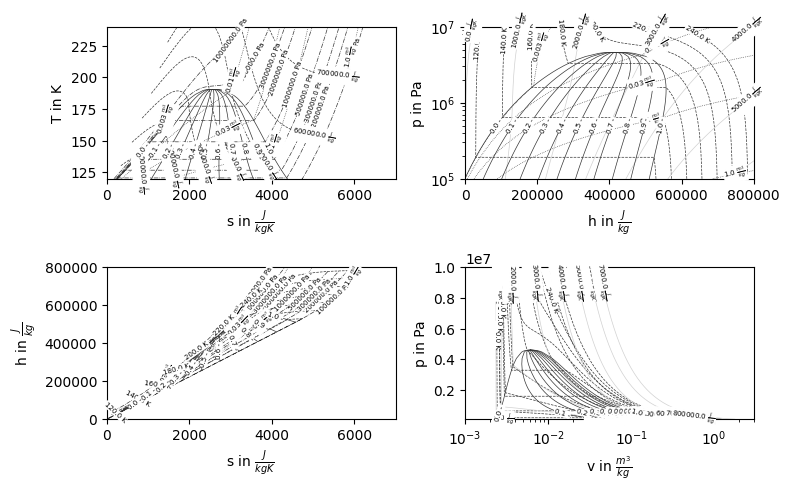

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

dg.draw_isolines(diagram_type='Ts', fig=fig, ax=ax[0,0], x_min=min(dg.entropy["isolines"]), x_max=max(dg.entropy["isolines"]), y_min=dg.T_min, y_max=dg.T_max)
dg.draw_isolines(diagram_type='logph', fig=fig, ax=ax[0,1], x_min=min(dg.enthalpy["isolines"]), x_max=max(dg.enthalpy["isolines"]), y_min=dg.p_min, y_max=dg.p_max)
dg.draw_isolines(diagram_type='hs', fig=fig, ax=ax[1,0], x_min=min(dg.entropy["isolines"]), x_max=max(dg.entropy["isolines"]), y_min=min(dg.enthalpy["isolines"]), y_max=max(dg.enthalpy["isolines"]))
dg.draw_isolines(diagram_type='plogv', fig=fig, ax=ax[1,1], x_min=min(dg.volume["isolines"]), x_max=max(dg.volume["isolines"]), y_min=dg.p_min, y_max=dg.p_max)

plt.tight_layout()